In [1]:
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
import seaborn as sns
sns.set_style("white")
pyplot.style.use('default')

# Init

## Load Dataset

In [2]:
## Load data from Drive (Colab only).
data_path = '../data/'

In [3]:
def convert(line):
    """Converts single JSON line and converts 'drawing' to list of np.array."""
    d = json.loads(line)
    d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
    return d
  
def loaditer(name, unrecognized=False, letter=False, scaled=False):
  """Returns iterable of drawings in specified file.

  Args:
    name: Name of the downloaded object (e.g. "elephant").
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  if(letter): 
    if(scaled):
      data_pathb = data_path+'/uji/'
    else:
      data_pathb = data_path+'/uji/no_scale/'
  else:
    data_pathb = data_path
  for line in tf.gfile.Open('%s/%s.ndjson' % (data_pathb, name)):
    d = convert(line)
    if unrecognized or d['recognized'] :
      yield d

def loadn(name, n, unrecognized=False, letter=False):
  """Returns list of drawings.

  Args:
    name: Name of the downloaded object (e.g. "elephant").
    n: Number of drawings to load.
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  it = loaditer(name, unrecognized=unrecognized, letter=letter)
  return list(itertools.islice(it, 0, n))

def loadALine(name,n,unrecognized=False,letter=False, scaled=False):
  count = 0
  if(letter): 
    if(scaled):
      data_pathb = data_path+'/uji/'
    else:
      data_pathb = data_path+'/uji/no_scale/'
  else:
    data_pathb = data_path
  for line in tf.gfile.Open('%s/%s.ndjson' % (data_pathb, name)):
    if(n == count):
      d = convert(line)
      if unrecognized or d['recognized'] :
          return d
    else:
      count +=1
      continue
  


In [4]:
import math

def findMinMax(letter): 
  xmin = min([row[0] for row in letter[0]])
  ymin = min([row[1] for row in letter[0]])
  xmax = max([row[0] for row in letter[0]])
  ymax = max([row[1] for row in letter[0]])
  for i in range(1,len(letter)): # for each stroke
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    
    if min(x) < xmin : xmin = min(x) 
    if max(x) > xmax : xmax = max(x) 
    if min(y) < ymin : ymin = min(y) 
    if max(y) > ymax : ymax = max(y)
  return {'xmin':xmin,'xmax':xmax,'ymin':ymin,'ymax':ymax}
  

def rotate_around_point_highperf(xy, radians, origin=(0, 0)):
  """Rotate a point around a given point.

  I call this the "high performance" version since we're caching some$
  values that are needed >1 time. It's less readable than the previous
  function but it's faster.
  """
  x, y = xy
  offset_x, offset_y = origin
  adjusted_x = (x - offset_x)
  adjusted_y = (y - offset_y)
  cos_rad = math.cos(radians)
  sin_rad = math.sin(radians)
  qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
  qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
  
  return [qx, qy]
  
def rotate_via_numpy(xy, radians):
  """Use numpy to build a rotation matrix and take the dot product."""
  x, y = xy
  c, s = np.cos(radians), np.sin(radians)
  j = np.matrix([[c, s, 0], [-s, c, 0], [0, 0, 1]])
  m = np.dot(j, [x, y, 1])

  return [float(m.T[0]), float(m.T[1])]

def rotate_path(stroke,radians):
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq = np.array(stroke.T, dtype=float)
  for i in range(0, len(sx)):
    q = rotate_via_numpy((sx[i],sy[i]),radians)
    sq[0][i] = q[0]
    sq[1][i] = q[1]
  return sq.T

def rotate_letter(letter,radians):
  letterc = letter.copy()
  for i in range(0,len(letter)):
    q = rotate_path(letter[i],radians)
    letterc[i] = q
  return letterc


def stroke_cart2polar(stroke): 
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq = np.array(stroke.T, dtype=float)
  for i in range(0, len(sx)):
    q = cart2polar(sx[i],sy[i])
    sq[0][i] = q[0]pca.components_
    sq[1][i] = q[1]
  return sq.T


def letter_cart2polar(letter): 
  letterc = letter.copy()
  for i in range(0,len(letter)):
    q = stroke_cart2polar(letter[i])
    letterc[i] = q
  return letterc


def cart2polar(x, y):
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(x, y)  # θ referenced to vertical
  return r, theta


def polar2cart(r, theta):
  y = r * np.cos(theta)   # θ referenced to vertical
  x = r * np.sin(theta)
  return x, y
  
  
def stroke_polar2cart(stroke): 
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq =  np.array(stroke.T, dtype=float)
  for i in range(0, len(sx)):
    q = polar2cart(sx[i],sy[i])
    sq[0][i] = q[0]
    sq[1][i] = q[1]
  return sq.T


def letter_polar2cart(letter): 
  letterc = letter.copy()
  for i in range(0,len(letter)):
    q = stroke_polar2cart(letter[i])
    letterc[i] = q
  return letterc



def plotLetter(letter):
  for stroke in letter['drawing']:
    xy = stroke.T
    pyplot.plot(xy[0,:], -xy[1,:])
    pxy = xy[:]
    # Indicate "point captured" with a red circle.
    pyplot.plot(pxy[0], -pxy[1], 'bo');
    pyplot.plot(pxy[0,0], -pxy[1,0], 'r*')
    
    
def plotLetterScaled(letter):
  for stroke in letter['drawing']:
    xy = stroke.T
    pyplot.plot(xy[0,:], xy[1,:])
    pxy = xy[:]
    # Indicate "point captured" with a red circle.
    pyplot.plot(pxy[0], pxy[1], 'bo');
    pyplot.plot(pxy[0,0], pxy[1,0], 'r*')
  
  
def rescale(letter):
  scaled_letter = [] 
  minmax = findMinMax(letter)
  #print(minmax)
  for i in range(0,len(letter)): # for each stroke
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    
    x = [(i - minmax['xmin'])/ (minmax['xmax']- minmax['xmin'])   for i in x]
    y = [(j - minmax['ymin'])/ (minmax['ymax']- minmax['ymin'])  for j in y]
    
    
    
    row = list(zip(x,y))
    scaled_letter.append(row)
  
  return scaled_letter


def rescaleLetter(letter):
  scaled_letter = letter.copy()
  minmax = findMinMax(letter)
  #print(minmax)
  for i in range(0,len(letter)): # for each stroke
    x = [row[0] for row in letter[i]]
    y = [row[1] for row in letter[i]]
    
    x = [(i - minmax['xmin'])/ (minmax['xmax']- minmax['xmin'])   for i in x]
    y = [(j - minmax['ymin'])/ (minmax['ymax']- minmax['ymin'])  for j in y]
    
    sq =  np.array(letter[i].T, dtype=float)
    sq[0] = x
    sq[1] = y
    
    scaled_letter[i] = sq.T
  
  return scaled_letter



def zstroke(stroke):
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq = np.array(stroke.T, dtype=float)
  sq = stats.zscore(sq, axis=1)
  return sq.T

def zletter(letter):
  sx = stroke.T[0]
  sy = stroke.T[1]
  sq = np.array(stroke.T, dtype=float)
  sq = stats.zscore(sq, axis=1)
  return sq.T
  

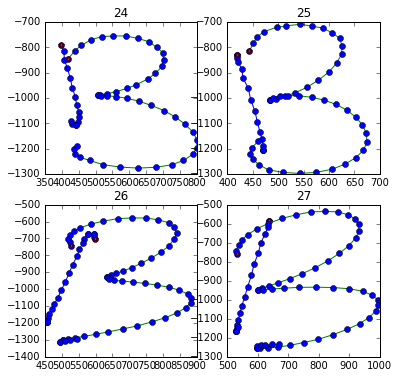

In [5]:
letterChar = 'B' #@param ["A", "a", "b", "B","C","c","L","l","O","o"] {allow-input: true}
minLet = 24 #@param {type:"slider", min:0, max:119, step:1}
nb = 2 #@param {type:"slider", min:2, max:10, step:1}

# Some more letters...
rows, cols = nb, 2

# Some more letters...
pyplot.figure(3)
pyplot.figure(figsize=(3*cols, 3*rows))
for y in range(rows):
  for x in range(cols):
    i = y * cols + x 
    pyplot.subplot(rows, cols, i + 1)
    pyplot.title(minLet+i)
    letter_sample = loadALine(letterChar,minLet+i, letter=True, unrecognized=True)
    plotLetter(letter_sample)
    #for s in letter_sample['drawing']:
    #  pyplot.plot(s.T[0], -s.T[1])


  
nice_l = {'B':28, 'A':21,'a':69,'b':61, 'C':37, 'c':89,'L':34, 'l':32, 'O':32, 'o':56}
#b 71, b 46

#  Preprocessing

done at the letter level

noramize and translate to 128

8 unit between 2 points in resampling

In [6]:
from matplotlib.patches import Rectangle
from sklearn import preprocessing
from scipy.interpolate import splprep
from scipy.signal import resample


def boxCenter(box):
  return ((box['xmax']-box['xmin'])/2, (box['ymax']-box['ymin'])/2)
  

def getBondingBox(letter):
  '''
  returns centroid, w and l and top left corner 
  
  '''
  
  minmax = findMinMax(letter['drawing'])
  centroid = boxCenter(minmax)
  size = (minmax['xmax'] - minmax['xmin'] , minmax['ymax'] - minmax['ymin'] )
  
  
  return (centroid, size, ( minmax['xmin'] , minmax['ymin'] ))


def drawBox(x,y,w,l):
  # Create a Rectangle patch
  rect = Rectangle((x,y),w,l,linewidth=1,edgecolor='r',facecolor='none')

  # Get the current reference
  ax = pyplot.gca()

  # Add the patch to the Axes
  ax.add_patch(rect)


def linearScaling(letter, dim=128):
  scaled_letter = letter.copy()
  minmax = findMinMax(letter['drawing'])
  for i in range(0, len(letter['drawing'])): # for each stroke
    x = [row[0] for row in letter['drawing'][i]]
    y = [row[1] for row in letter['drawing'][i]]
    
    x = [float(j - minmax['xmin'])/ (minmax['xmax']- minmax['xmin'])   for j in x]
    y = [float(j - minmax['ymin'])/ (minmax['ymax']- minmax['ymin'])  for j in y]
    y = [j * -1 for j in y]
    
    sq =  np.array(letter['drawing'][i].T, dtype=float)
    
    sq[0] = x
    sq[1] = y 
    
    scaled_letter['drawing'][i] = sq.T *dim
  
  return scaled_letter


'''def resampleLetter(letter,eq=8):
  scaled_letter = letter.copy()
  
  for i in range(0,len(letter['drawing'])): # for each stroke
    sq =  np.array(letter['drawing'][i], dtype=float)
    x = [row[0] for row in sq]
    y = [row[1] for row in sq]
    print(len(x))
    x =  resample(x, eq)
    y =  resample(y, eq)
    print(len(x))
    
    sq[0] = x
    sq[1] = y 
    
    
    scaled_letter['drawing'][i] = sq
  
  return scaled_letter
'''
  

def translation():
  '''
  Centers the drawing in a w,h size
  '''
  
  return
  

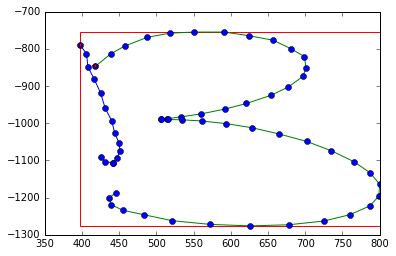

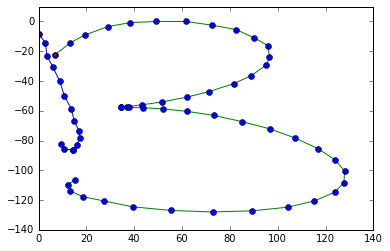

In [20]:
letterChar = 'B' #@param ["A", "a", "b", "B","C","c","L","l","O","o"] {allow-input: true}
minLet = 24 #@param {type:"slider", min:0, max:119, step:1}



letter_sample = loadALine(letterChar,minLet, letter=True, unrecognized=True)

centroid, size, ori = getBondingBox(letter_sample)
w,l = size
xm, ym = ori
drawBox(xm,-ym,w,-l)
# print(letter_sample)
plotLetter(letter_sample)

pyplot.figure(3)
pyplot.ylim((-140, 10))
scaled = linearScaling(letter_sample)
plotLetterScaled(scaled)

# HBF49 Features

## Dynamic Features for each stroke

- starting point position (f1, f2)
- ending point position (f3, f4)
- first to last point vector v 

In [8]:
def f1(stroke, centroid, dim):
  return (stroke[0,0] - centroid[0])/dim +1/2 

def f2(stroke, centroid, dim):
  return (stroke[0,1] - centroid[1])/dim +1/2 

def f3(stroke, centroid, dim):
  return (stroke[-1,0] - centroid[0])/dim +1/2 

def f4(stroke, centroid, dim):
  return (stroke[-1,1] - centroid[1])/dim +1/2 


In [9]:
from numpy import linalg as LA
from scipy.spatial import distance

def getVEndStart(stroke):
  return np.array([stroke[-1,0] - stroke[0,0], stroke[-1,1] - stroke[0,1]])

def f5(vendstart):
  return LA.norm(vendstart)

def f6(vendstart): #c53
  ux = np.array([1,0])
  nv  =  vendstart / LA.norm(vendstart)
  a = np.dot(nv,ux)
  print(a)
  return np.cos(a)

def f7(vendstart): #c54
  uy = np.array([0,1])
  nv  =  vendstart / LA.norm(vendstart)
  a = np.dot(nv,uy)
  print(a)
  return np.sin(a)

In [10]:
from math import hypot

def getLengthPath(stroke):
  lengths = np.sqrt(np.sum(np.diff(stroke, axis=0)**2, axis=1)) # Length between corners
  total_length = np.sum(lengths)
  return total_length

def getLengthLetter(letter):
  lengths = [getLengthPath(s) for s in letter['drawing']]
  total_length = np.sum(lengths)
  return total_length

def f8(vendstart,l): #D8 Closure
  return f5(vendstart)/l

In [11]:
s = letter_sample['drawing'][1]
v = getVEndStart(s)
l = getLengthPath(s)
ll = getLengthLetter(letter_sample)

f8(v, l)
print(l)

430.67425430003266


In [12]:
def getInitialVect(stroke): ## consider vect between first and third point
  return np.array([stroke[2,0] - stroke[0,0], stroke[2,1] - stroke[0,1]])

def f9(initVect):
  return f6(initVect)

def f10(initVect):
  return f7(initVect)
  

In [13]:
def getMiddlePoint(stroke):
  m = int(len(stroke)/2)
  return stroke[m]

def f11(stroke, m, dim):
  return 1/w * (m[0] - (stroke[0,0] + stroke[-1,0])/2)

def f12(stroke, m, dim):
  return 1/w * (m[1] - (stroke[0,1] + stroke[-1,1])/2)

m = getMiddlePoint(s)
f12(s,m,128)

0.0

In [14]:
import math

def f14(letter):
  return letter['nb_stroke']

f14(letter_sample)


centroid, size, ori = getBondingBox(letter_sample)
w,l = size
xm, ym = ori

## Visual Features

In [80]:

def f15(size):
  w,h = size
  return math.atan(h/w)

def f16(letter):
  return getLengthLetter(letter)

def f17(l_length, size):
  w,h = size
  return (w+h)/l_length
  
def centroidLetter(letter):
  centroids = [ centroidStroke(stroke) for stroke in letter['drawing']]  
  return np.average(centroids, axis=0)

def centroidStroke(arr):
  sum_x = np.sum(arr[:, 0])
  sum_y = np.sum(arr[:, 1])
  return [float(sum_x)/len(arr), float(sum_y)/len(arr)]

def f18(stroke, centroid):
  deviations = [np.abs(si - centroid) for si in stroke]
  print(deviations)
  return np.average(deviations, axis=0)


In [16]:
centroidd = centroidLetter(letter_sample)
centroidd

array([ 37.8842162 , -60.84246015])

In [17]:
def f19(stroke): 
  directions = [np.arctan((stroke[i+1][1]- stroke[i][1])/stroke[i+1][0]- stroke[i][0]) for i in range(len(stroke)-1)]
  return np.average(directions, axis=0)
  

In [18]:
import math

def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def arccos(v1, v2):
  return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))

def thetaI(stroke, i):
  return arccos(stroke[i] - stroke[i-1], stroke[i+1] -stroke[i])


def f20(stroke):
  curvatures = [thetaI(stroke, i) for i in range(2, len(stroke)-1)]
  filt = filter(lambda v: v==v, curvatures) ## filter out the nan values
  curvatures = [x for x in filt]
  return np.sum(curvatures)

def f21(stroke):
  curvatures = [math.pow(math.sin(thetaI(stroke, i)),2) for i in range(2, len(stroke)-1)]
  filt = filter(lambda v: v==v, curvatures) ## filter out the nan values
  curvatures = [x for x in filt]
  return np.sum(curvatures)

def thetaIk(stroke, i, k):
  return arccos(stroke[i] - stroke[i-k], stroke[i+k] -stroke[i])

def f22(stroke, k):
  curvatures = [math.pow(math.sin(thetaIk(stroke, i, k)),2) for i in range(2, len(stroke)-1)]
  filt = filter(lambda v: v==v, curvatures) ## filter out the nan values
  curvatures = [x for x in filt]
  return np.sum(curvatures)

def f23(stroke, k):
  curvatures = [thetaIk(stroke, i, k) for i in range(2, len(stroke)-1)]
  filt = filter(lambda v: v==v, curvatures) ## filter out the nan values
  curvatures = [x for x in filt]
  return np.max(curvatures)



In [19]:
def segmentOrientation(stroke, i):
  si =  stroke[i+1] -stroke[i]
  ux = [length(si), 0]
  return arccos(si, ux)

segmentOrientation(s,8)

def segmentOrientationList(stroke):
  segtO = [segmentOrientation(stroke, i) for i in range(len(stroke) -1)]
  return segtO
  
lh = segmentOrientationList(s)
np.histogram(lh, bins=8)

ValueError: autodetected range of [nan, nan] is not finite

In [ ]:
(10.608436724565758 + 65.15999568453985)/2

In [269]:
letter_sample = loadALine(letterChar,minLet, letter=True, unrecognized=True)
letter_scaled = linearScaling(letter_sample)
stroke = letter_sample['drawing'][1]
stroke = np.array(stroke, dtype = float)
stroke
# plotLetter(letter_sample)
# letter_sample['drawing']

array([[   6.66997519,  -22.60268714],
       [  13.33995037,  -14.24952015],
       [  19.37468983,   -9.09021113],
       [  28.90322581,   -3.43953935],
       [  38.43176179,   -0.73704415],
       [  48.91315136,   -0.        ],
       [  61.617866  ,   -0.        ],
       [  72.41687345,   -2.45681382],
       [  82.58064516,   -5.4049904 ],
       [  90.20347395,  -11.05566219],
       [  95.92059553,  -16.21497121],
       [  96.55583127,  -23.58541267],
       [  95.2853598 ,  -29.23608445],
       [  88.93300248,  -36.36084453],
       [  81.62779156,  -41.76583493],
       [  71.14640199,  -47.17082534],
       [  61.93548387,  -50.85604607],
       [  51.77171216,  -54.04990403],
       [  43.19602978,  -56.01535509],
       [  37.16129032,  -57.243762  ],
       [  34.62034739,  -57.48944338],
       [  34.62034739,  -57.48944338],
       [  37.79652605,  -57.73512476],
       [  43.83126551,  -57.98080614],
       [  52.08933002,  -58.71785029],
       [  62.25310174,  -

## Sonntag/Weber Features

In [46]:
def a1(stroke): #number of strokes
    return len(stroke)

In [67]:
def a2(stroke):
    return getLengthPath(stroke)
a2(stroke)

349.714431248784

### Convex Hull

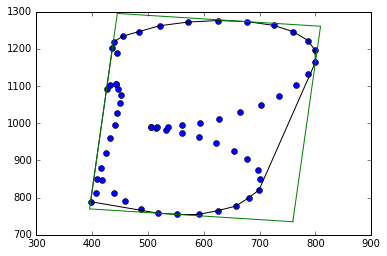

In [49]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Polygon, LineString

def getAllStrokes(letter):
    letter_points = []
    for each_stroke in letter['drawing']:
        for each_point in each_stroke:
            letter_points.append(each_point)
    points = np.array(letter_points)
    return points

def GetHull(letter): #Get Convex Hull
    points = getAllStrokes(letter)
    hull = ConvexHull(points)
    return hull

# PlotAndGetHull(letter_sample)
def PlotHull(letter): #Plot Convex Hull
    points = getAllStrokes(letter)
    hull = GetHull(letter)
    pyplot.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        pyplot.plot(points[simplex, 0], points[simplex, 1], 'k-')
    
def a3(letter): #Area of Convex Hull
    hull = GetHull(letter)
    return hull.volume

def a4(letter): #Perimeter of Convex Hull
    points = getAllStrokes(letter)
    hull = ConvexHull(points)
    hull_arr = []
    for vertex in hull.vertices:
        hull_arr.append(points[vertex])
    hull_arr = np.array(hull_arr)
    return Polygon(hull_arr).length

def a5(letter): #Compactness
    return (a4(letter)**2)/a3(letter)

def getAxes(letter):
    points = getAllStrokes(letter)
    hull = GetHull(letter)
    hull_arr = []
    for vertex in hull.vertices:
        hull_arr.append(points[vertex])
    hull_arr = np.array(hull_arr)
    polygon =  Polygon(hull_arr)
    # get the minimum bounding rectangle and zip coordinates into a list of point-tuples
    mbr_points = list(zip(*polygon.minimum_rotated_rectangle.exterior.coords.xy))
#     print(mbr_points)
    # calculate the length of each side of the minimum bounding rectangle
    mbr_lengths = [LineString((mbr_points[i], mbr_points[i+1])).length for i in range(len(mbr_points) - 1)]
    # get major/minor axis measurements
    minor_axis = min(mbr_lengths)
    major_axis = max(mbr_lengths)
    return major_axis, minor_axis

def a6(letter): #Eccentricity
    a, b = getAxes(letter)
    return np.sqrt(1 - b**2/a**2)

def a7(letter): #Principal Axes
    a, b = getAxes(letter)
    return b/a

def a9(letter): #Principal Axes
    a, b = getAxes(letter)
    A = a3(letter)
    return A/(a*b)

def a10(stroke, letter): #Closure
    return LA.norm(stroke[0] - stroke[-1])/a4(letter)

# plotLetter(letter_sample)
PlotHull(letter_sample)
a6(letter_sample)
# [(130.65705982243603, -122.19575691116628), (114.65181500718955, 8.59054301226798), (-0.3512191550686471, -5.483191907526066), (15.654025660177808, -136.26949183096033), (130.65705982243603, -122.19575691116628)]
pyplot.plot([759.4048404519311, 809.1428488015647, 444.90420109187505, 395.1661927422415, 759.4048404519311], [735.1485709280937, 1260.585992467813, 1295.064893585963, 769.627472046244, 735.1485709280937])
# scaled = linearScaling(letter_sample)
# plotLetterScaled(scaled)
# pyplot.show()

In [50]:
def a8(stroke): #Circular Variance
    mu = centroidStroke(stroke)
    deviations = [LA.norm(si - mu) for si in stroke]
    mu_r = np.average(deviations)
    deviations_new = (deviations - mu_r)**2
    return np.average(deviations_new)/mu_r**2

### Angle between successive vectors

In [51]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / LA.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def a11(stroke): #Curvature
    sum = 0.0
    for i in range(1, len(stroke) - 1):
        if(np.isnan(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])) == False):
            sum += angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])
    return sum

def a12(stroke): #Perpendicularity
    sum = 0.0
    for i in range(1, len(stroke) - 1):
        if(np.isnan(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])) == False):
            sum += np.sin(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i]))**2
    return sum

def a13(stroke): #Signed Perpendicularity
    sum = 0.0
    for i in range(1, len(stroke) - 1):
        if(np.isnan(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])) == False):
            sum += np.sin(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i]))**3
    return sum
a13(stroke)    

0.9461122475210325

## Rubine Features

In [52]:
def b1(stroke):#Cosine of initial angle
    return (stroke[2][0] - stroke[0][0])/(LA.norm(stroke[2] - stroke[0]))
b1(stroke)

0.18032786885245902

In [53]:
def b2(stroke):#Sine of initial angle
    return (stroke[2][1] - stroke[0][1])/(LA.norm(stroke[2] - stroke[0]))
b2(stroke)

0.9836065573770492

In [54]:
def findMinMax_letter_sample(letter_sample):
    letter = letter_sample['drawing']  
    xmin = min([row[0] for row in letter[0]])
    ymin = min([row[1] for row in letter[0]])
    xmax = max([row[0] for row in letter[0]])
    ymax = max([row[1] for row in letter[0]])
    for i in range(1,len(letter)): # for each stroke
        x = [row[0] for row in letter[i]]
        y = [row[1] for row in letter[i]]

        if min(x) < xmin : xmin = min(x) 
        if max(x) > xmax : xmax = max(x) 
        if min(y) < ymin : ymin = min(y) 
        if max(y) > ymax : ymax = max(y)
    return {'xmin':xmin,'xmax':xmax,'ymin':ymin,'ymax':ymax}

def b3(letter_sample): #Length of bounding box diagonal for letter
    bbox = findMinMax_letter_sample(letter_sample)
    print(bbox)
    return np.sqrt((bbox['xmax'] - bbox['xmin'])**2 + (bbox['ymax'] - bbox['ymin'])**2)
b3(letter_sample)
# letter_sample['drawing']

{'xmin': 397, 'ymin': 755, 'ymax': 1276, 'xmax': 800}


658.6729082025463

In [55]:
def b4(letter_sample): #Angle of bounding box diagonal for stroke
    bbox = findMinMax_letter_sample(letter_sample)
    return np.arctan((bbox['ymax'] - bbox['ymin']) / (bbox['xmax'] - bbox['xmin']))
b4(letter_sample)
# letter_sample['drawing']

0.7853981633974483

In [56]:
def b5(stroke): #Distance between first and last point
    return LA.norm(stroke[-1] - stroke[0])
b5(stroke)

303.3891889965758

In [57]:
def b6(stroke): # Cosine of the angle between first and last point
    return (stroke[-1][0] - stroke[0][0])/b5(stroke)
b6(stroke)

0.0955867942951893

In [58]:
def b7(stroke): # Sine of the angle between first and last point
    return (stroke[-1][1] - stroke[0][1])/b5(stroke)
b7(stroke)

0.9954210992119713

In [59]:
def b8(stroke): # Total gesture length
    diff_arr = np.diff(stroke, axis = 0)
    sum_arr = np.sqrt(np.sum(diff_arr**2, axis = 1))
#     print(diff_arr)
    return np.sum(sum_arr)
b8(stroke)

349.714431248784

### Requires calculating angle at each point

In [60]:
def getThetas(stroke): 
    diff_arr = np.diff(stroke, axis = 0)
    theta = []
    for i in range(1, len(diff_arr)):
        num = diff_arr[i][0]*diff_arr[i - 1][1] - diff_arr[i - 1][0]*diff_arr[i][1]
        den = diff_arr[i][0]*diff_arr[i - 1][0] + diff_arr[i][1]*diff_arr[i - 1][1]
#         print(den)
        if(den != 0):
            theta.append(np.arctan(num/den))
    theta_arr = np.array(theta)
    return theta_arr

def b9(stroke): #Total angle traversed
    theta_arr = getThetas(stroke)
    return np.sum(theta_arr)

def b10(stroke): #Sum of the absolute value of the angle at each point
    theta_arr = getThetas(stroke)
    return np.sum(np.abs(theta_arr))

def b11(stroke): #Sum of the squared value of the angle at each point
    theta_arr = getThetas(stroke)
    return np.sum(theta_arr**2)
b11(stroke)

5.543730208789693

## Features by Willems and Niels

In [65]:
def c1(stroke): #Length of the gesture
    diff_norm_sum = np.sum(LA.norm(np.diff(stroke, axis = 0), axis = 1))
    return diff_norm_sum
    
c1(stroke)

349.714431248784

In [66]:
def c2(letter): #Area of convex hull
    return a3(letter)
c2(letter_sample)

163602.0

In [ ]:
def c3(letter): # Compactness
    return a5(letter)

### Coordinate Axes

In [181]:
def getCoAxes(stroke): # Ratio between co-ordinate axes
    a = stroke[0][0]
    b = stroke[0][1]
    for j in range(len(stroke)):
        for i in range(j + 1):
            if(np.abs(stroke[i][0] - stroke[j][0]) > a):
                a = np.abs(stroke[i][0] - stroke[j][0])
            if(np.abs(stroke[i][1] - stroke[j][1]) > b):
                b = np.abs(stroke[i][1] - stroke[j][1])
    if(a > b):
        a_prime = a
        b_prime = b
    else:
        a_prime = b
        b_prime = a
    return float(a_prime), float(b_prime)

def getCoAxes_ab(stroke):
    a = stroke[0][0]
    b = stroke[0][1]
    for j in range(len(stroke)):
        for i in range(j):
            if(np.abs(stroke[i][0] - stroke[j][0]) > a):
                a = np.abs(stroke[i][0] - stroke[j][0])
            if(np.abs(stroke[i][1] - stroke[j][1]) > b):
                b = np.abs(stroke[i][1] - stroke[j][1])
    return a, b

def c4(stroke):
    a_prime, b_prime = getCoAxes(stroke)
    return np.sqrt(1 - float(b_prime)**2/a_prime**2)

def c5(stroke):
    a_prime, b_prime = getCoAxes(stroke)
    return b_prime/a_prime
        
c4(stroke)

def c35(stroke): # Initial horizontal offset
    a, b = getCoAxes_ab(stroke)
    return (stroke[0][0] - np.min(stroke[:,0]))/float(a)

def c36(stroke): # Final horizontal offset
    a, b = getCoAxes_ab(stroke)
    return (stroke[-1][0] - np.min(stroke[:,0]))/float(a)
c36(stroke)

def c37(stroke): # Initial vertical offset
    a, b = getCoAxes_ab(stroke)
    return (stroke[0][1] - np.min(stroke[:,1]))/float(b)
c37(stroke)

def c38(stroke): # Final vertical offset
    a, b = getCoAxes_ab(stroke)
    return (stroke[-1][1] - np.min(stroke[:,1]))/float(b)
c38(stroke)

0.8641882852542606

In [74]:
def c6(stroke):
    den = LA.norm(stroke[-1] - stroke[0])
    return c1(stroke)/den
c6(stroke)

1.1526924621322978

In [82]:
def c7(stroke): #Circular Variance
    return a8(stroke)
c7(stroke)

[430.4, 990.6]


0.2585948323359016

In [83]:
def c8(stroke): # Curvature
    return a11(stroke)
c8(stroke)

2.5455156412227335

In [84]:
def c9(stroke): # Average Curvature
    sum, count = 0.0, 0
    for i in range(1, len(stroke) - 1):
        if(np.isnan(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])) == False):
            count = count + 1
            sum += angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])
    return sum/count
c9(stroke)

0.2314105128384303

In [85]:
def c10(stroke): # Standard deviation in curvature
    c9_val = c9(stroke)
    sum, count = 0.0, 0
    for i in range(1, len(stroke) - 1):
        if(np.isnan(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])) == False):
            count = count + 1
            sum += (angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i]) - c9_val)**2
    return sum/count
c10(stroke)

0.06874139192612218

In [99]:
def c12(stroke): # Average direction
    diff = np.diff(stroke, axis = 0)
    sum, count = 0.0, 0
    for i in range(len(diff)):
        if(diff[i][0] != 0):
            count += 1
            sum += np.arctan(diff[i][1]/diff[i][0])
    return sum/count
c12(stroke)

0.8178598303902296

In [106]:
def c13(stroke):
    return a12(stroke)
c13(stroke)

1.1633832598484886

In [108]:
def c14(stroke): #Perpendicularity
    sum = 0.0
    count = 0
    for i in range(1, len(stroke) - 1):
        if(np.isnan(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])) == False):
            count += 1
            sum += np.sin(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i]))**2
    return sum/count
c14(stroke)

0.09281684857881821

In [109]:
def c15(stroke): #Standard Deviation in Perpendicularity
    sum = 0.0
    count = 0
    c14_val = c14(stroke)
    for i in range(1, len(stroke) - 1):
        if(np.isnan(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])) == False):
            count += 1
            sum += (np.sin(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i]))**2 - c14_val)**2
    return sum/count
c15(stroke)

### Using the Principal Axes

In [187]:
from sklearn.decomposition import PCA

def getAxesPCA(letter):
    points = getAllStrokes(letter)
    pca = PCA(n_components=2)
    return pca.fit(points).components_

def getc(letter): # Get center of bounding box
    c = np.zeros(2)
    offset, _, minmax = getBondingBox(letter)
    c[0] = minmax[0] + offset[0]
    c[1] = minmax[1] + offset[1]
    return c

def c16(letter, stroke): # Centroid offset
#     p1, p2 = getAxes(letter)
    p1, p2 = getAxesPCA(letter)
    mu = centroidStroke(stroke)
    c = getc(letter)
#     print(p2)
    return abs(np.dot(p2,mu))

def c17(letter, stroke): # Length of first principal axis
    p1, p2 = getAxesPCA(letter)
    mu = centroidStroke(stroke)
    c = getc(letter)
    alpha = 2*np.max(np.matmul(stroke - c, p2))
    return alpha
c17(letter_sample, stroke)

def c18(letter, stroke): # Sine orientation of principal axis
    p1, p2 = getAxesPCA(letter)
    return p1[1]

def c19(letter, stroke): # Cosine orientation of principal axis
    p1, p2 = getAxesPCA(letter)
    return p1[0]

def c20(letter, stroke): # Rectangularity
    p1, p2 = getAxesPCA(letter)
    mu = centroidStroke(stroke)
    c = getc(letter)
    beta = 2*np.max(np.matmul(stroke - c, p1))
    alpha = 2*np.max(np.matmul(stroke - c, p2))
    A = a3(letter)
    return A/(alpha*beta)
c20(letter_sample, stroke)

0.38276299112801015

### Cups

1

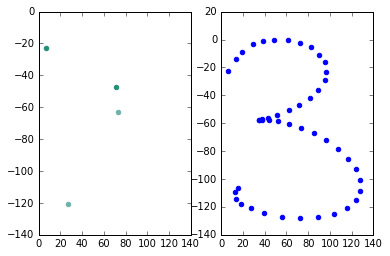

In [284]:
from random import randint

def cmap_ints():
    i = randint(1, 10000)
    return "#"+hex(((int(i)+1)*2396745)%(256**3))[2:].rjust(6,"0")

def c32(stroke): # Number of cups
    t_w = 15
    t_a = 30
    n_cups = 0
#     pos = 0
    N = len(stroke)
    pyplot.subplot(1,2,1)
    pyplot.xlim(0,140)
#     for i in range(N - t_w):
    i = 0
    while(i + t_w < N):
#         print(math.degrees(angle_between(stroke[i], stroke[i + t_w])))
#         if(math.degrees(angle_between(stroke[i], stroke[i + t_w])) > t_a and (pos == 0 or pos < i - t_w)):
        if(math.degrees(angle_between(stroke[i], stroke[i + t_w])) > t_a):
            pyplot.scatter([stroke[i, 0], stroke[i + t_w,0]], [stroke[i, 1], stroke[i + t_w,1]], color = cmap_ints())
#             pos = i
            i += t_w + 1
            n_cups += 1
        else:
            i += 1
    pyplot.subplot(1,2,2)
    pyplot.scatter(stroke[:,0], stroke[:,1], color = 'b', marker = 'o')
    return n_cups
c32(stroke)

def c33(stroke): # Offset of the First Cup
    t_w = 15
    t_a = 30
    N = len(stroke)
    for i in range(N - t_w):
        if(math.degrees(angle_between(stroke[i], stroke[i + t_w])) > t_a):
            return (i + 1)/N
c33(stroke)

def c34(stroke): # Offset of the Last Cup
    t_w = 15
    t_a = 45
    N = len(stroke)
    for i in range(N - t_w - 1, -1, -1):
        if(math.degrees(angle_between(stroke[i], stroke[i + t_w])) > t_a):
            return (i + 1 + t_w)/N
    return -1
c34(stroke)

### Straight Lines

0.23723474635923092

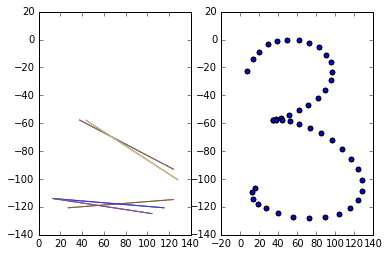

In [324]:
def d_func(stroke, k1, k2, i, o):
    v = np.matmul(np.array([(0, -1), (1, 0)]), stroke[k2] - stroke[k1])
    return np.abs(np.dot(v, stroke[i] - stroke[o]))/LA.norm(v)

def isStraightLine(stroke, i, j):
    t_d = 10
    k1 = i + (j - i)/3
    k2 = i + (2*(j - i))/3
    for o in range(i,j + 1):
        if(d_func(stroke, k1, k2, i, o) > t_d):
            return False
    return True
            

def straight_lines(stroke): #Get the straight lines
    L = []
    N = len(stroke)
    t_l = 80
    pyplot.subplot(1,2,1)
    pyplot.xlim(0,140)
    pyplot.ylim(-140,20)
    for i in range(N - 4):
        for j in range(N - 1, i + 2, -1):
            if(isStraightLine(stroke, i, j)):
                if(LA.norm(stroke[i] - stroke[j - 1]) > t_l):
                    L.append(stroke[i] - stroke[j])
                    pyplot.plot([stroke[i, 0], stroke[j,0]], [stroke[i, 1], stroke[j,1]], color = cmap_ints())
                i = j
                break;
    pyplot.subplot(1,2,2)
    pyplot.scatter(stroke[:,0], stroke[:,1])
    return L

def c39(stroke): # Number of straight lines
    return len(straight_lines(stroke))

def c40(stroke): # Average length of straight lines
    L = straight_lines(stroke)
    L = np.array(L)
    norm_arr = LA.norm(L, axis = 1)
#     print(norm_arr, L)
    return np.average(norm_arr)        
c40(stroke)

def c41(stroke): # Standard deviation of straight line length
    c40_val = c40(stroke)
    L = straight_lines(stroke)
    L = np.array(L)
    norm_arr = LA.norm(L, axis = 1)
    sd_arr = (norm_arr - c40_val)**2
#     print(sd_arr)
    return np.sqrt(np.average(sd_arr))

def c42(stroke): # Straight line ratio
    L = straight_lines(stroke)
    L = np.array(L)
    norm_arr = LA.norm(L, axis = 1)
#     print(norm_arr, L)
    return np.sum(norm_arr)/c1(stroke)  
c42(stroke)

def c43(stroke): # Largest straight line ratio
    L = straight_lines(stroke)
    L = np.array(L)
    norm_arr = LA.norm(L, axis = 1)
#     print(norm_arr, L)
    return np.max(norm_arr)/c1(stroke)
c43(stroke)

### 48, 49, 52, 53, 54 done previously

In [ ]:
def c50(stroke): #Length of bounding box diagonal for stroke
    a, b = getCoAxes_ab(stroke)
    return LA.norm([a,  b])
c50(stroke)

In [330]:
def c51(stroke): #Angle of the bounding box diagonal for stroke
    a, b = getCoAxes_ab(stroke)
    return np.arctan(b/a)
c51(stroke)

0.8121433769211204

In [331]:
def c56(stroke): #Squared Curvature
    sum = 0.0
    for i in range(1, len(stroke) - 1):
        if(np.isnan(angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])) == False):
            sum += angle_between(stroke[i] - stroke[i - 1], stroke[i + 1] - stroke[i])**2
    return sum
c56(stroke)

3.9375155919694595

In [337]:
def c57(stroke, k): #Macro Perpendicularity
    sum = 0.0
    for i in range(k, len(stroke) - k):
        if(np.isnan(angle_between(stroke[i] - stroke[i - k], stroke[i + k] - stroke[i])) == False):
            sum += np.sin(angle_between(stroke[i] - stroke[i - k], stroke[i + k] - stroke[i]))**2
    return sum
c57(stroke, 3)

13.495108821908048

In [340]:
def c58(stroke, k): #Average Macro Perpendicularity
    c57_val = c57(stroke, k)
    return c57_val/(len(stroke) - 2*k)
c58(stroke, 3)

0.3373777205477012

In [ ]:
def c59(stroke, k): #Standard Deviation in Macro Perpendicularity
    sum = 0.0
    c58_val = c58(stroke, k)
    for i in range(k, len(stroke) - k):
        if(np.isnan(angle_between(stroke[i] - stroke[i - k], stroke[i + k] - stroke[i])) == False):
            sum += (np.sin(angle_between(stroke[i] - stroke[i - k], stroke[i + k] - stroke[i]))**2 - c58_val)**2
    return np.sqrt(sum/(len(stroke) - 2*k))
c58(stroke, 3)

In [342]:
def c60(letter, stroke): # Ratio of Principal A
    p1, p2 = getAxesPCA(letter)
    c = getc(letter)
    beta = 2*np.max(np.matmul(stroke - c, p1))
    alpha = 2*np.max(np.matmul(stroke - c, p2))
    return beta/alpha
c60(letter_sample, stroke)

1.0949521278897705

In [ ]:
def c61(stroke): # Average Centroidal Radius
    mu = centroidStroke(stroke)
    deviations = [LA.norm(si - mu) for si in stroke]
    mu_r = np.average(deviations)
    return mu_r

In [ ]:
def c62(stroke): # 69 Standard deviation of the centroidal radius
    return np.sqrt(a8(stroke))

In [ ]:
## INCOMPLETE ##
def c63(stroke, num): # Chain codes
    s = num/2
    shi_s = angle_between(stroke[s] - stroke[s - 1], stroke[s + 1] - stroke[s])
    if(np.isnan(shi_s) == False):
        if(0 <= shi_s and shi_s < math.pi/4):
            C_s = 1
        elif(math.pi/4 <= shi_s and shi_s < math.pi/2):
            C_s = 2
        elif(math.pi/2 <= shi_s and shi_s < 3*math.pi/4):
            C_s = 3
        elif(3*math.pi/4 <= shi_s and shi_s < math.pi):
            C_s = 4
        elif(math.pi <= shi_s and shi_s < 5*math.pi/4):
            C_s = 5
        elif(5*math.pi/4 <= shi_s and shi_s < 3*math.pi/2):
            C_s = 6
        elif(3*math.pi/2<= shi_s and shi_s < 7*math.pi/4):
            C_s = 7
        elif(7*th.pi/4 <= shi_s and shi_s < 2*math.pi):
            C_s = 8
        shi_Cs = (C_s - 0.5)*math.pi/4
        return np.sin(shi_Cs), np.cos(shi_Cs)


In [345]:
def c64(letter): # Average Stroke Length
    lengths_arr = []
    for each_stroke in letter['drawing']:
        lengths_arr.append(c1(each_stroke))
    return np.average(np.array(lengths_arr))
c64(letter_sample)

259.36710578431126

In [346]:
def c65(letter): #Standard Deviation in Stroke Length
    lengths_arr = []
    c64_val = c64(letter)
    for each_stroke in letter['drawing']:
        lengths_arr.append((c1(each_stroke) - c64_val)**2)
    return np.sqrt(np.average(np.array(lengths_arr)))
c65(letter_sample)

171.3071485157214

### Stroke Direction

In [356]:
def phi(stroke):
    diff = np.diff(stroke, axis=0)
    angle_arr = []
    for point in diff:
        if(np.isnan(np.arctan(point[1]/point[0])) == False):
            angle_arr.append(np.arctan(point[1]/point[0]))
    return np.average(np.array(angle_arr))
phi(stroke)

def c66(letter): # Average stroke direction
    sum_arr = []
    for each_stroke in letter['drawing']:
        if(np.isnan(phi(each_stroke)) == False):
            sum_arr.append(phi(each_stroke))
    return np.average(np.array(sum_arr))
c66(letter_sample)

def c67(letter): # Standard deviation in stroke direction
    sum_arr = []
    c66_val = c66(letter)
    for each_stroke in letter['drawing']:
        if(np.isnan(phi(each_stroke)) == False):
            sum_arr.append((phi(each_stroke) - c66_val)**2)
    return np.average(np.array(sum_arr))
c67(letter_sample)

0.18321301961420977

In [228]:
math.degrees(arccos(np.array([0, 1]), np.array([1, -2])))

153.434948822922

In [352]:
# arr1 = np.array([(1, 2), (3, 4)])
# arr2 = np.array([(5, 6), (7, 8)])
# arr1[0] - arr2[-1]
# arr = np.array([2, 3, 4])
# (arr - 1)**2
# stroke
# np.average(stroke, axis = 0)
# arr = np.array([(1, 0), (0, 1)], axis = 0)
# np.max(np.array([ -0.28762178,  0.95774407]))
# stroke 
# pyplot.scatter(stroke[:,0], stroke[:,1])
# stroke
# letter_sample['drawing'][0], letter_sample['drawing'][1]
angle_arr = []
np.average(np.array(angle_arr))

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)


nan

# TO DO
- Implement bounding box for stroke
- Ask which bounding box method is better (PCA or Convex Hull)
- arccos always between (0, pi). 
- Connected Components